In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pygeos
import pyproj
from scipy.stats import linregress

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [11]:
# set data paths to results
data_random_attack = r'C:\Data\Global_Percolation\percolation_results_random_attack_regular'
data_targeted_attack = r'C:\Data\Global_Percolation\percolation_results_targeted_attack'
data_local_attack_05 = r'C:\Data\Global_Percolation\percolation_results_local_attack_05'
data_local_attack_01 = r'C:\Data\Global_Percolation\percolation_results_local_attack_01'
data_local_attack_005 = r'C:\Data\Global_Percolation\percolation_results_local_attack_005'

data_path_met= r'C:\Data\Global_Percolation\percolation_metrics'
data_path_net = r'C:\Data\Global_Percolation\percolation_networks'
data_path_grids = r'C:\Data\Global_Percolation\percolation_grids'

# file to get full country names
glob_info = pd.read_excel(r'C:\Projects\trails\data\global_information.xlsx')
gdp_cap_country = pd.read_csv(r'C:\trails\data\percolation\worldbank_gdp_2019.csv',sep=';')
income_groups = pd.read_excel(r'C:\trails\data\percolation\CLASS.xls',sheet_name='Groups')

# get all files from data paths
perc_files = os.listdir(data_random_attack)
perc_files_targeted_attack = os.listdir(data_targeted_attack)
perc_files_local_attack_05 = os.listdir(data_local_attack_05)
perc_files_local_attack_01 = os.listdir(data_local_attack_01)
perc_files_local_attack_005 = os.listdir(data_local_attack_005)

grid_files = os.listdir(data_path_grids)

met_files = os.listdir(data_path_met)
net_files = os.listdir(data_path_net)

In [3]:
income_groups = income_groups.loc[(income_groups.GroupName.str.contains('High income')) | (
     income_groups.GroupName.str.contains('Upper middle income')) | (
     income_groups.GroupName.str.contains('Lower middle income')) | (
     income_groups.GroupName.str.contains('Low income'))].reset_index(drop=True)
#income_groups.loc[income_groups.GroupName.str.contains('Low income')]

In [4]:
gadm36 = gpd.read_file(r'C:/Data/Global_Geospatial/GADM/gadm36_levels.gpkg',layer=0)


In [22]:
gadm36['area'] = pygeos.area(pygeos.from_shapely(gadm36.geometry))

In [23]:
py_geoms = pygeos.from_shapely(gadm36.geometry.values)

In [24]:
def get_area_km2(geometries):
    """This method adds a distance column using pygeos (converted from shapely) 
    assuming the new crs from the latitude and longitude of the first node
    distance is in metres

    Args:
        network (class): A network composed of nodes (points in space) and edges (lines)

    Returns:
        network (class): A network composed of nodes (points in space) and edges (lines)
    """    

    #Find crs of current df and arbitrary point(lat,lon) for new crs
    current_crs="epsg:4326"
    #The commented out crs does not work in all cases
    #current_crs = [*network.edges.crs.values()]
    #current_crs = str(current_crs[0])
    lat = pygeos.get_y(pygeos.centroid(geometry))
    lon = pygeos.get_x(pygeos.centroid(geometry))
    # formula below based on :https://gis.stackexchange.com/a/190209/80697 
    approximate_crs = "epsg:" + str(int(32700-np.round((45+lat)/90,0)*100+np.round((183+lon)/6,0)))
    #from pygeos/issues/95
    coords = pygeos.get_coordinates(geometry)
    transformer=pyproj.Transformer.from_crs(current_crs, approximate_crs,always_xy=True)
    new_coords = transformer.transform(coords[:, 0], coords[:, 1])
    result = pygeos.set_coordinates(geometry, np.array(new_coords).T)
    return pygeos.area(result)

In [25]:
collect_area = []
for geometry in tqdm(py_geoms,total=len(py_geoms)):
    collect_area.append(get_area_km2(geometry)/1e6) 
gadm36['area'] = collect_area

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:17<00:00, 14.53it/s]


In [28]:
area_dict = dict(zip(gadm36['GID_0'],gadm36['area']))
continent_dict = dict(zip(glob_info['ISO_3digit'],glob_info['continent']))
gdp_cap_dict = dict(zip(gdp_cap_country['iso'],gdp_cap_country['gdp']))
income_dict = dict(zip(income_groups['CountryCode'],income_groups['GroupName']))

In [54]:
collect_max_isolated_5perc = {}
collect_max_isolated_10perc = {}
collect_max_isolated_20perc = {}
collect_mean_isolated_5perc = {}
collect_mean_isolated_10perc = {}
collect_mean_isolated_20perc = {}
collect_min_isolated_5perc = {}
collect_min_isolated_10perc = {}
collect_min_isolated_20perc = {}

collect_max_e2surloss_5perc = {}
collect_max_e2surloss_10perc = {}
collect_max_e2surloss_20perc = {}
collect_mean_e2surloss_5perc = {}
collect_mean_e2surloss_10perc = {}
collect_mean_e2surloss_20perc = {}
collect_min_e2surloss_5perc = {}
collect_min_e2surloss_10perc = {}
collect_min_e2surloss_20perc = {}

collect_metrics = {}

for iter1,file in tqdm(enumerate(perc_files),total=len(perc_files)):

    net_name = file[:5]
    
    if not (net_name.endswith('_0')):
        continue
    
    if net_name[:3] in ['AIA','COK','BES','BLM','GGY','GLP','GUF','MSR','REU',
                        'JEY','CXR','ESH','FLK','GUM','HKG','IMN','MTQ','WLF',
                        'MAC','MNP','NFK','SHN','VAT','XAD','MYT','NIU','XKO',]:
        continue
    
    #try:
    net_name = dict(zip(glob_info.ISO_3digit,glob_info.Country))[net_name[:3]]
    df_metrics = pd.read_csv(os.path.join(data_path_met,[x for x in met_files if file[:5] in x][0]))

    df = pd.read_csv(os.path.join(data_random_attack,file),index_col=[0])

    max_5perc = df.groupby('frac_counter').quantile(q=0.95).loc[0.05]
    try:
        max_10perc = df.groupby('frac_counter').quantile(q=0.95).loc[0.10]
    except:
        max_10perc = df.groupby('frac_counter').quantile(q=0.95).loc[df.groupby('frac_counter').quantile(q=0.95).index.max()]
    try:
        max_20perc = df.groupby('frac_counter').quantile(q=0.95).loc[0.20]
    except:
        max_20perc = df.groupby('frac_counter').quantile(q=0.95).loc[df.groupby('frac_counter').quantile(q=0.95).index.max()]


    mean_5perc = df.groupby('frac_counter').mean().loc[0.05]    
    try:
        mean_10perc = df.groupby('frac_counter').mean().loc[0.10]    
    except:
        mean_10perc = df.groupby('frac_counter').mean().loc[df.groupby('frac_counter').mean().index.max()]
    try:
        mean_20perc = df.groupby('frac_counter').mean().loc[0.20] 
    except:
        mean_20perc = df.groupby('frac_counter').mean().loc[df.groupby('frac_counter').mean().index.max()]


    min_5perc = df.groupby('frac_counter').quantile(q=0.05).loc[0.05]    
    try:
        min_10perc = df.groupby('frac_counter').quantile(q=0.05).loc[0.10]    
    except:
        min_10perc = df.groupby('frac_counter').quantile(q=0.05).loc[df.groupby('frac_counter').quantile(q=0.05).index.max()]        
    try:
        min_20perc = df.groupby('frac_counter').quantile(q=0.05).loc[0.20]        
    except:
        min_20perc = df.groupby('frac_counter').quantile(q=0.05).loc[df.groupby('frac_counter').quantile(q=0.05).index.max()]        


    collect_metrics[net_name] = [continent_dict[file[:3]],
                                 gdp_cap_dict[file[:3]],
                                 income_dict[file[:3]],
                                 area_dict[file[:3]],
                                 df_metrics.Total_Edge_Length.values[0],
                                 df_metrics.Density.values[0],
                                 df_metrics.Edge_Connectivity.values[0],
                                 df_metrics.Edge_No.values[0],   
                                 df_metrics.Clique_No.values[0],                                
                                 df_metrics.Ave_Path_Length.values[0],
                                 df_metrics.Assortativity.values[0],
                                 df_metrics.Diameter.values[0],
                                 df_metrics.Max_Degree.values[0],
                                 df_metrics.Transivitity.values[0],
                                 df_metrics.Articulation_Points.values[0],
                                max_5perc['pct_isolated'],
                                max_10perc['pct_isolated'],
                                max_20perc['pct_isolated'],
                                mean_5perc['pct_isolated'],
                                mean_10perc['pct_isolated'],
                                mean_20perc['pct_isolated'],
                                min_5perc['pct_isolated'],
                                min_10perc['pct_isolated'],
                                min_20perc['pct_isolated'],
                                max_5perc['total_pct_surplus_loss_e2'],
                                max_10perc['total_pct_surplus_loss_e2'],
                                max_20perc['total_pct_surplus_loss_e2'],
                                mean_5perc['total_pct_surplus_loss_e2'],
                                mean_10perc['total_pct_surplus_loss_e2'],
                                mean_20perc['total_pct_surplus_loss_e2'],
                                min_5perc['total_pct_surplus_loss_e2'],
                                min_10perc['total_pct_surplus_loss_e2'],
                                min_20perc['total_pct_surplus_loss_e2']      
                                ]      
# except:
#         print(net_name)


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [00:36<00:00,  7.74it/s]


In [55]:
save_pct_isolated = {}
for iter1,file in tqdm(enumerate(perc_files),total=len(perc_files)):
    try:
        net_name = file[:5]
        net_name = dict(zip(glob_info.ISO_3digit,glob_info.Country))[net_name[:3]]
        df = pd.read_csv(os.path.join(data_path_perc,file),index_col=[0])    
        save_pct_isolated[net_name] = df.groupby('frac_counter').quantile(q=0.5)['pct_isolated']
    except:
        continue

100%|██████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 9679.22it/s]


In [56]:
df_agg = df.groupby('frac_counter').min().reset_index() 
df_agg = df_agg.fillna(0)

In [57]:
country_metrics = pd.DataFrame.from_dict(collect_metrics,orient='index')
country_metrics = pd.concat([country_metrics],axis=1)
country_metrics.columns = ['Continent',
                           'GDP_Capita',
                           'IncomeGroup',
                           'Area',
                           'Total_Edge_Length',
                           'Density',
                           'Edge_Connectivity',
                           'Edge_No',
                           'Clique_No',
                           'Ave_Path_Length', 
                           'Assortativity', 
                           'Diameter',
                           'Max_Degree',
                           "Transivitity",
                           "Articulation_Points",
                           'max_5perc_isolated',
                           'max_10perc_isolated',
                           'max_20perc_isolated',
                           'mean_5perc_isolated',
                           'mean_10perc_isolated',
                           'mean_20perc_isolated',
                           'min_5perc_isolated',
                           'min_10perc_isolated',
                           'min_20perc_isolated',
                           'max_5perc_surloss_e2',
                           'max_10perc_surloss_e2',
                           'max_20perc_surloss_e2',
                           'mean_5perc_surloss_e2',
                           'mean_10perc_surloss_e2',
                           'mean_20perc_surloss_e2',
                           'min_5perc_surloss_e2',
                           'min_10perc_surloss_e2',
                           'min_20perc_surloss_e2'                         
                          ]

In [58]:
country_metrics['areaLog'] = np.log(country_metrics.Area)
country_metrics['edgeLog'] = np.log(country_metrics.Total_Edge_Length)
country_metrics['edgeAreaLog'] = np.log(country_metrics.Total_Edge_Length/country_metrics.Area)

In [59]:
country_metrics.to_csv('random_attack.csv')

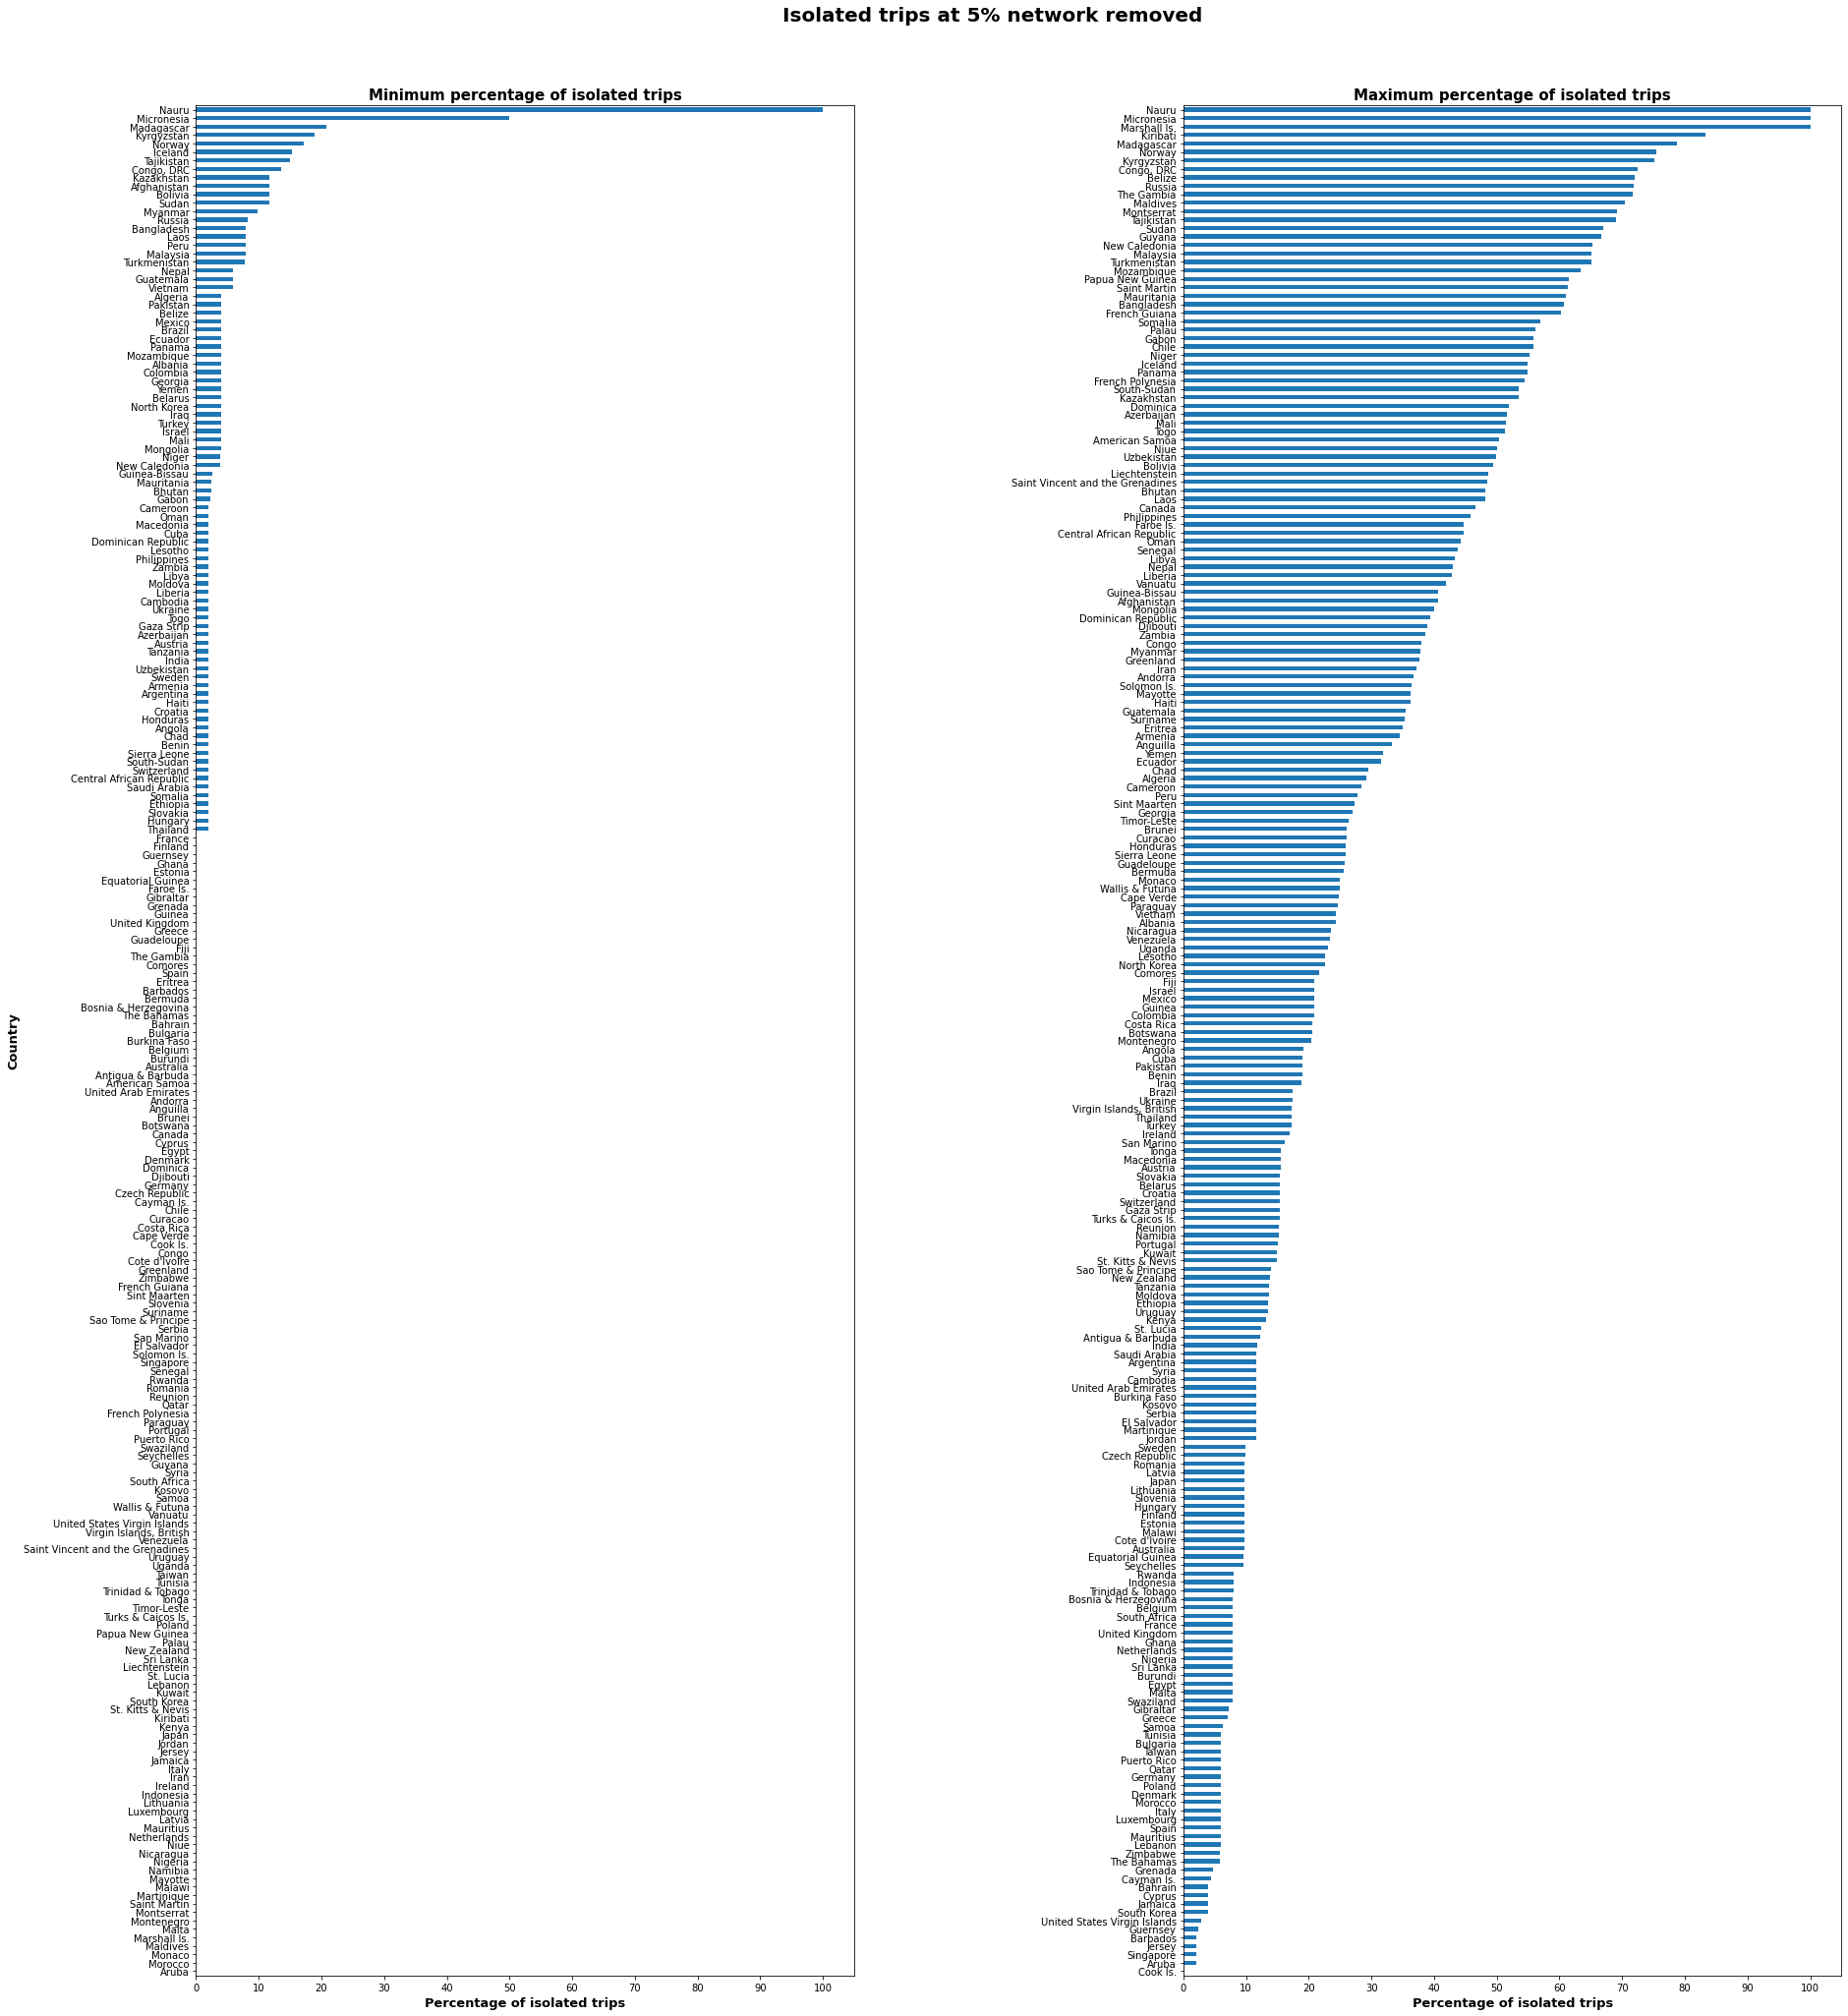

In [17]:
fig, axs = plt.subplots(1,2,figsize=(30,35),gridspec_kw={'hspace': 0.1, 'wspace': 0.5})

for iter2,ax in enumerate(axs.flatten()):
    if iter2 == 0:
        country_metrics.min_5perc_isolated.sort_values().dropna().plot.barh(ax=ax)
        ax.set_title('Minimum percentage of isolated trips', fontsize=15, fontweight='bold')    
        ax.set_ylabel('Country', fontsize=13, fontweight='bold')     
    elif iter2 == 1:
        country_metrics.max_5perc_isolated.sort_values().dropna().plot.barh(ax=ax)
        ax.set_title('Maximum percentage of isolated trips', fontsize=15, fontweight='bold')                    
    # else:
    #     country_metrics.max_20perc_isolated.sort_values().dropna().plot.barh(ax=ax)
    #     ax.set_title('Difference maximum and minimum percentage of isolated trips', fontsize=15, fontweight='bold')                    
        
        
    ax.set_xlabel('Percentage of isolated trips', fontsize=13, fontweight='bold')  
    
    ax.set_xticks(np.arange(0, 100+2, 10))
    
fig.suptitle('Isolated trips at 5% network removed', fontsize=20, fontweight='bold', y=0.92)

plt.savefig(os.path.join('..','overview_figures','5perc_isolated_trips.png'),dpi=500,facecolor='white', transparent=False)

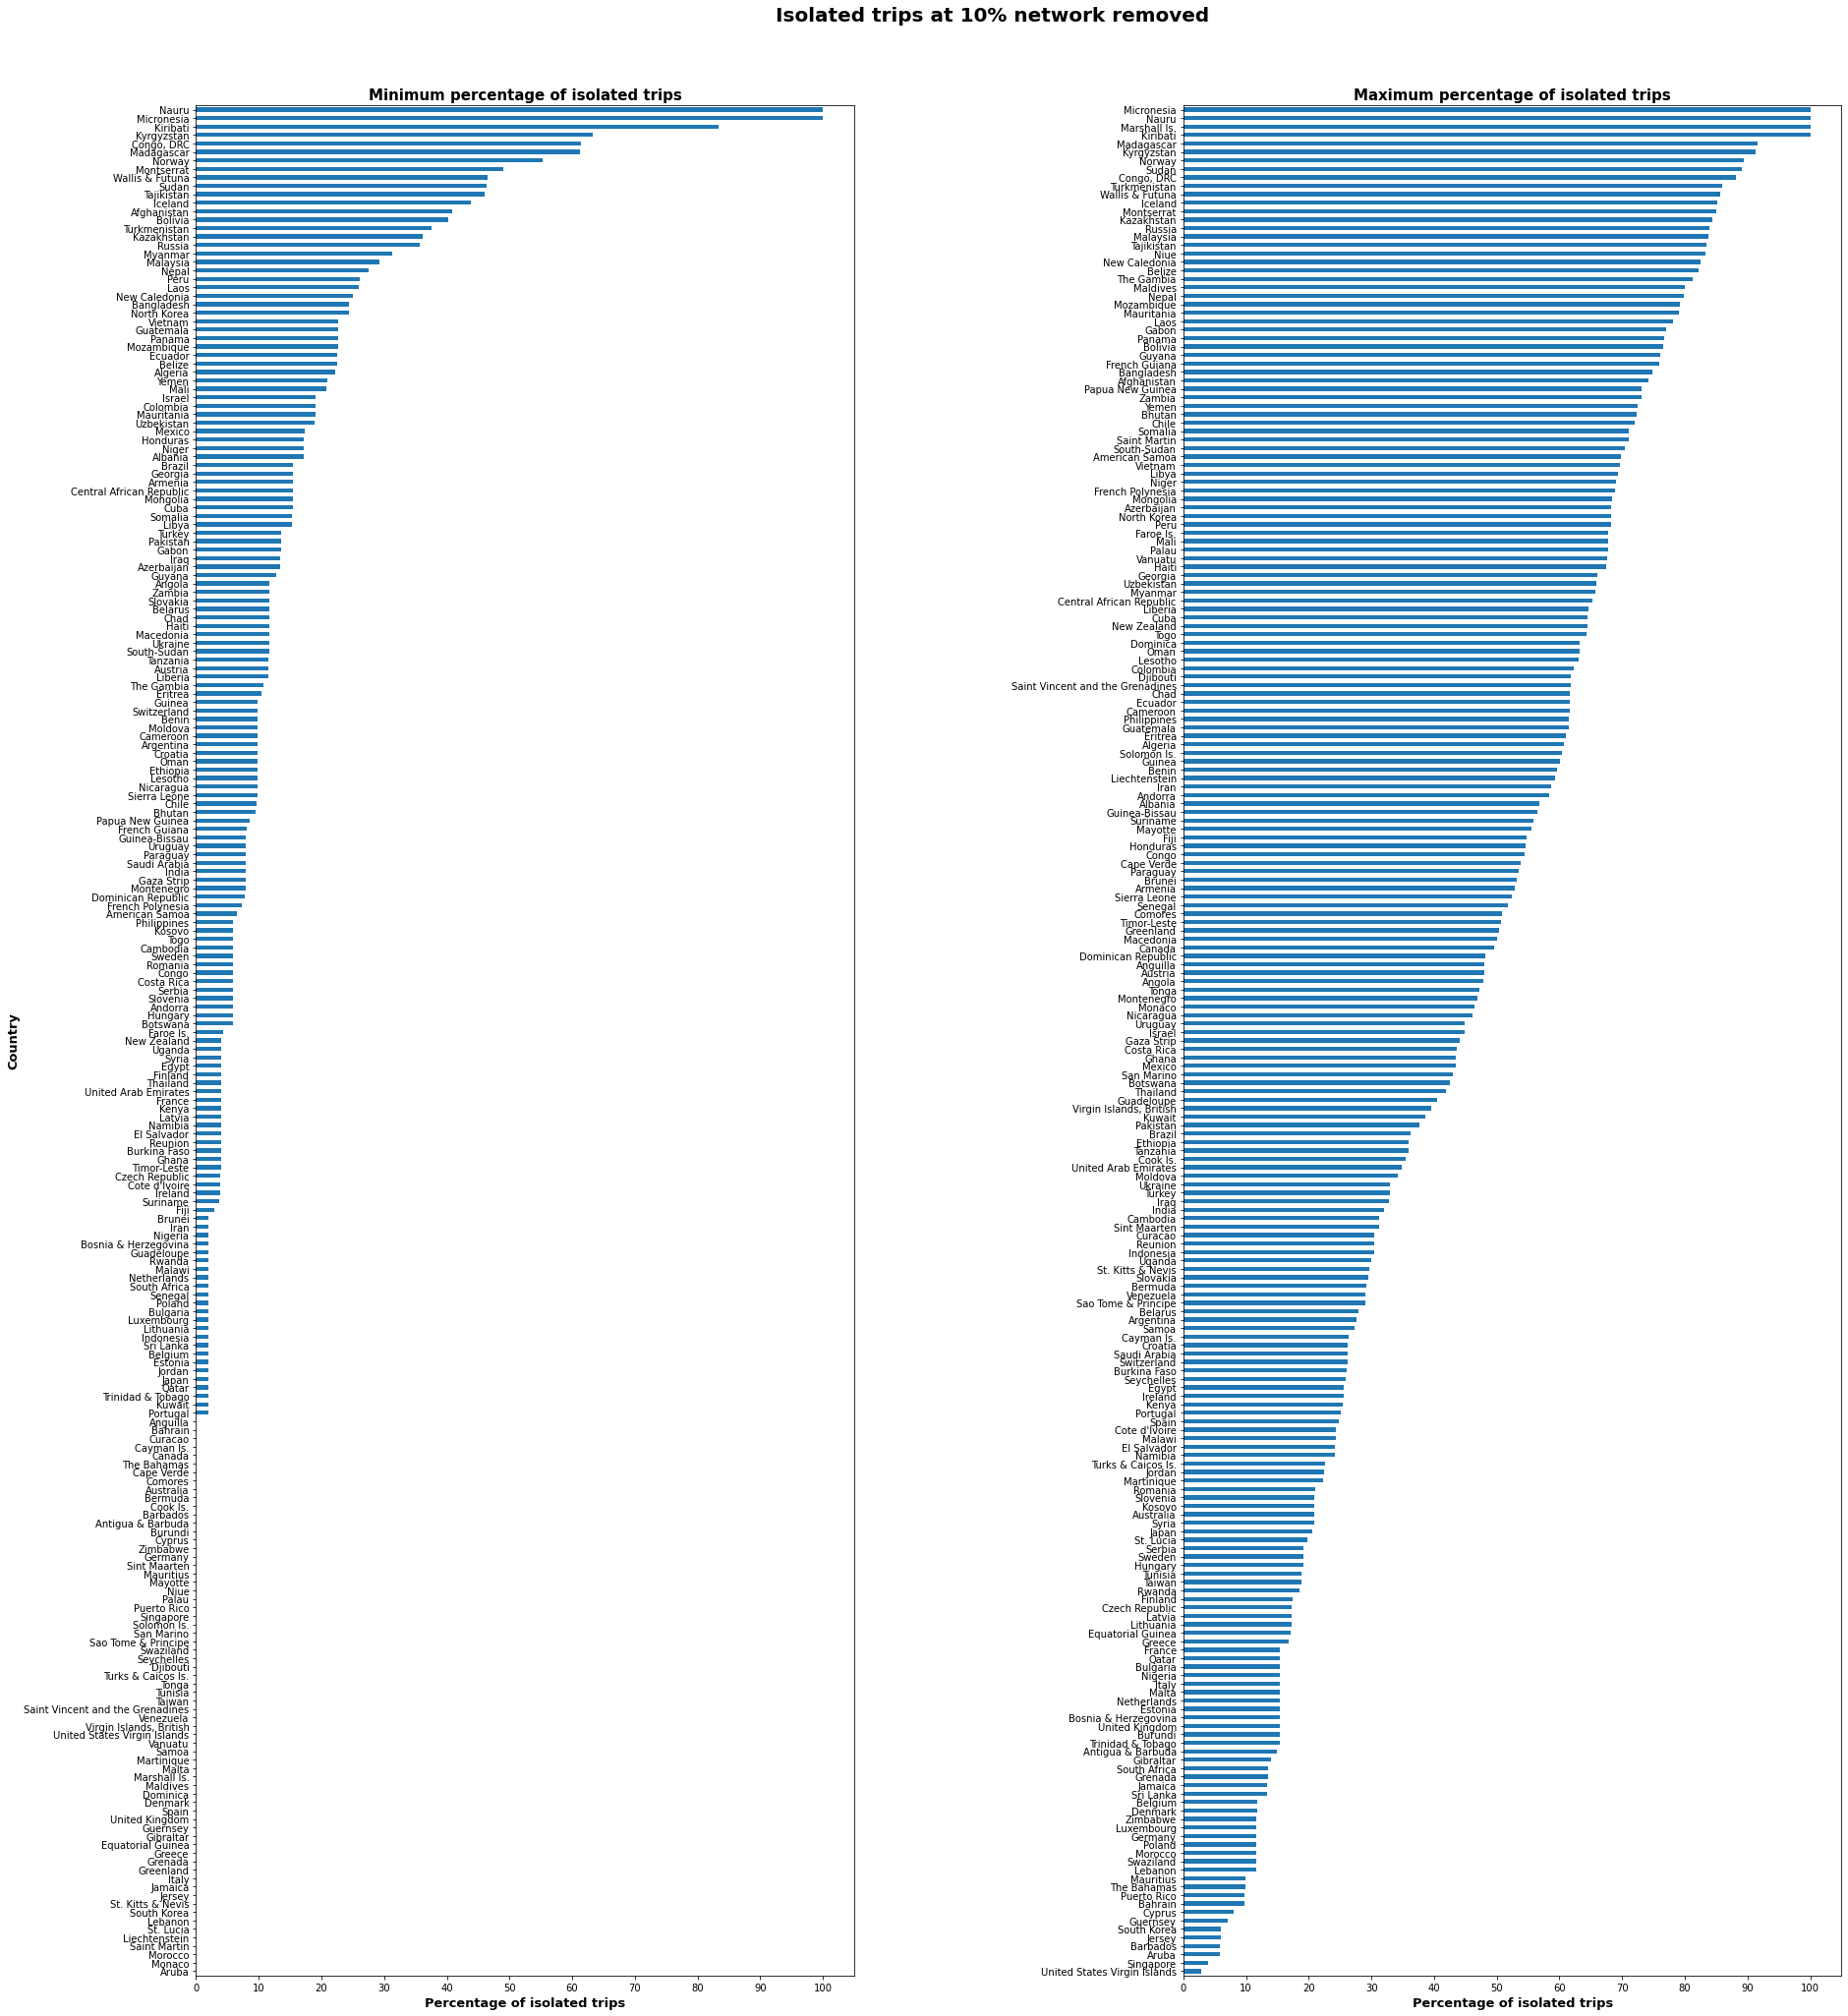

In [18]:
fig, axs = plt.subplots(1,2,figsize=(30,35),gridspec_kw={'hspace': 0.1, 'wspace': 0.5})

for iter2,ax in enumerate(axs.flatten()):
    if iter2 == 0:
        country_metrics.min_10perc_isolated.sort_values().dropna().plot.barh(ax=ax)
        ax.set_title('Minimum percentage of isolated trips', fontsize=15, fontweight='bold')    
        ax.set_ylabel('Country', fontsize=13, fontweight='bold')     
    elif iter2 == 1:
        country_metrics.max_10perc_isolated.sort_values().dropna().plot.barh(ax=ax)
        ax.set_title('Maximum percentage of isolated trips', fontsize=15, fontweight='bold')                    
    # else:
    #     country_metrics.max_20perc_isolated.sort_values().dropna().plot.barh(ax=ax)
    #     ax.set_title('Difference maximum and minimum percentage of isolated trips', fontsize=15, fontweight='bold')                    
        
        
    ax.set_xlabel('Percentage of isolated trips', fontsize=13, fontweight='bold')  
    
    ax.set_xticks(np.arange(0, 100+2, 10))
    
fig.suptitle('Isolated trips at 10% network removed', fontsize=20, fontweight='bold', y=0.92)

plt.savefig(os.path.join('..','overview_figures','10perc_isolated_trips.png'),dpi=500,facecolor='white', transparent=False)

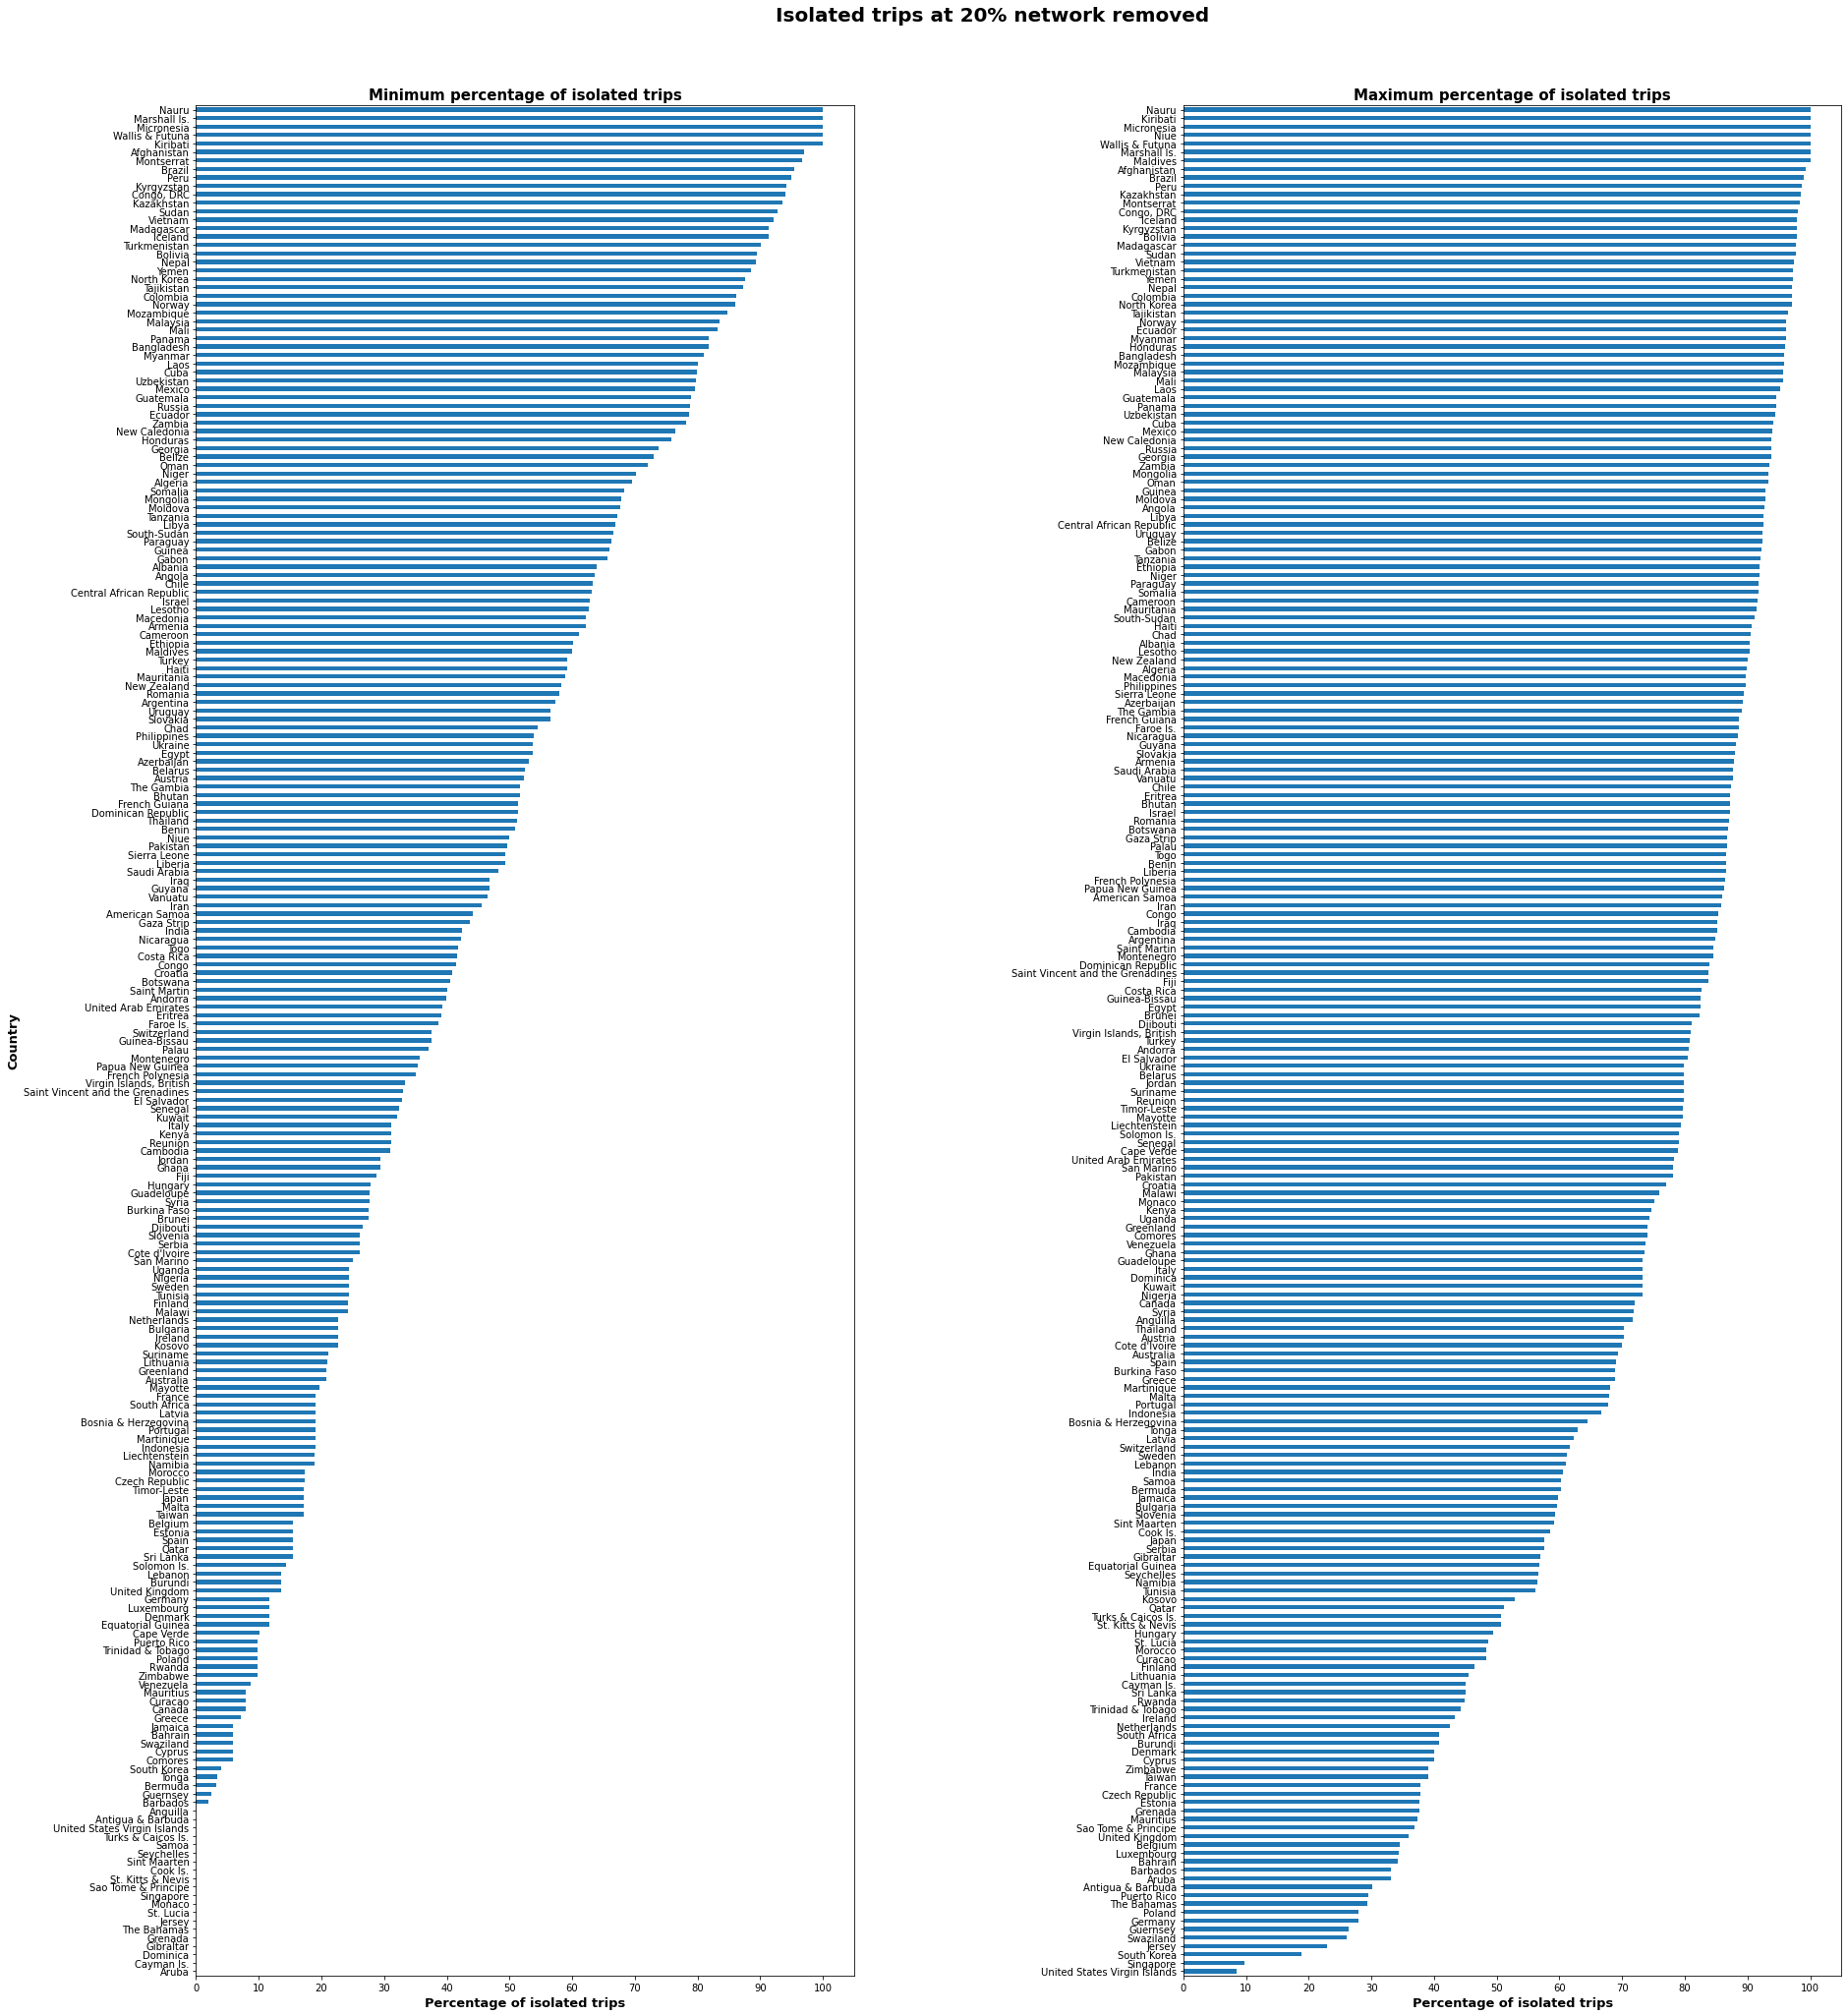

In [19]:
fig, axs = plt.subplots(1,2,figsize=(30,35),gridspec_kw={'hspace': 0.1, 'wspace': 0.5})

for iter2,ax in enumerate(axs.flatten()):
    if iter2 == 0:
        country_metrics.min_20perc_isolated.sort_values().dropna().plot.barh(ax=ax)
        ax.set_title('Minimum percentage of isolated trips', fontsize=15, fontweight='bold')    
        ax.set_ylabel('Country', fontsize=13, fontweight='bold')     
    elif iter2 == 1:
        country_metrics.max_20perc_isolated.sort_values().dropna().plot.barh(ax=ax)
        ax.set_title('Maximum percentage of isolated trips', fontsize=15, fontweight='bold')                    
    # else:
    #     country_metrics.max_20perc_isolated.sort_values().dropna().plot.barh(ax=ax)
    #     ax.set_title('Difference maximum and minimum percentage of isolated trips', fontsize=15, fontweight='bold')                    
        
        
    ax.set_xlabel('Percentage of isolated trips', fontsize=13, fontweight='bold')  
    
    ax.set_xticks(np.arange(0, 100+2, 10))
    
fig.suptitle('Isolated trips at 20% network removed', fontsize=20, fontweight='bold', y=0.92)

plt.savefig(os.path.join('..','overview_figures','20perc_isolated_trips.png'),dpi=500,facecolor='white', transparent=False)